In [3]:
library('zoo')
library('forecast')
library('readxl')
library('urca')
library('tseries')
library('fUnitRoots')


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'forecast' was built under R version 4.0.5"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'readxl' was built under R version 4.0.5"
Warning message:
"package 'urca' was built under R version 4.0.5"
Warning message:
"package 'fUnitRoots' was built under R version 4.0.5"
Loading required package: timeDate

Loading required package: timeSeries


Attaching package: 'timeSeries'


The following object is masked from 'package:zoo':

    time<-


Loading required package: fBasics

Warning message:
"package 'fBasics' was built under R version 4.0.2"

Attaching package: 'fUnitRoots'


The following objects are masked from 'package:urca':

    punitroot, qunitroot, unitrootTable




In [4]:
data <- read.csv("../dataset/期货价格数据/使用数据/CBOT大豆周连续.csv",head=F)
head(data)

,V1,V2
,<chr>,<dbl>
1,1972/1/10,304.63
2,1972/1/17,307.63
3,1972/1/24,309.38
4,1972/1/31,318.75
5,1972/2/7,314.75
6,1972/2/14,314.38


In [5]:
data2 <- data[2]
data_ts <- ts(data2,start=1,frequency=52)
head(data_ts)

V2
304.63
307.63
309.38
318.75
314.75
314.38


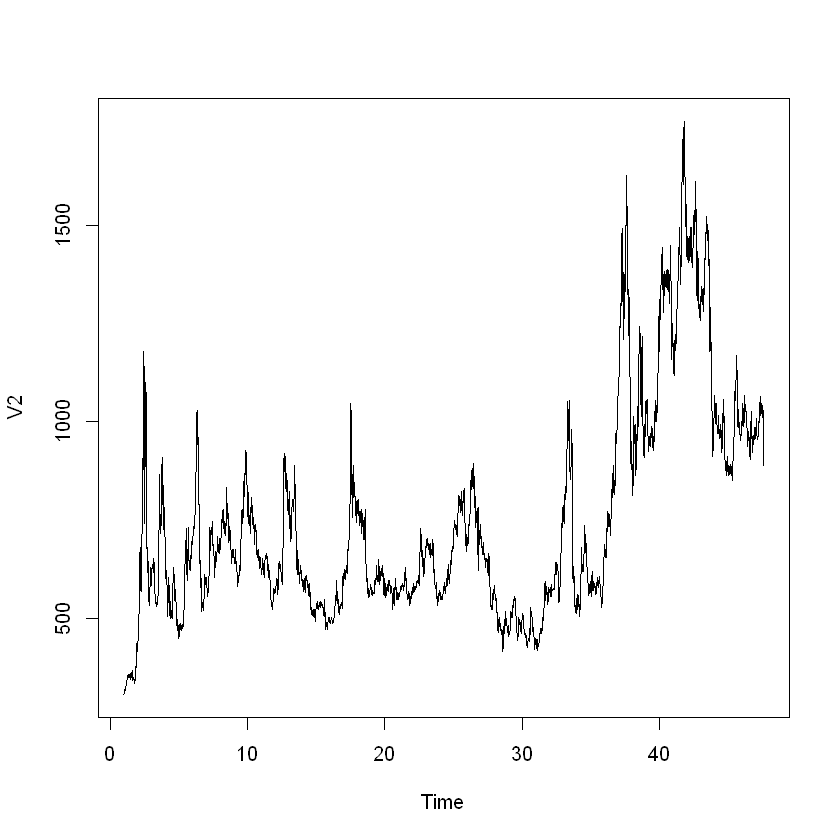

In [6]:
plot.ts(data_ts)

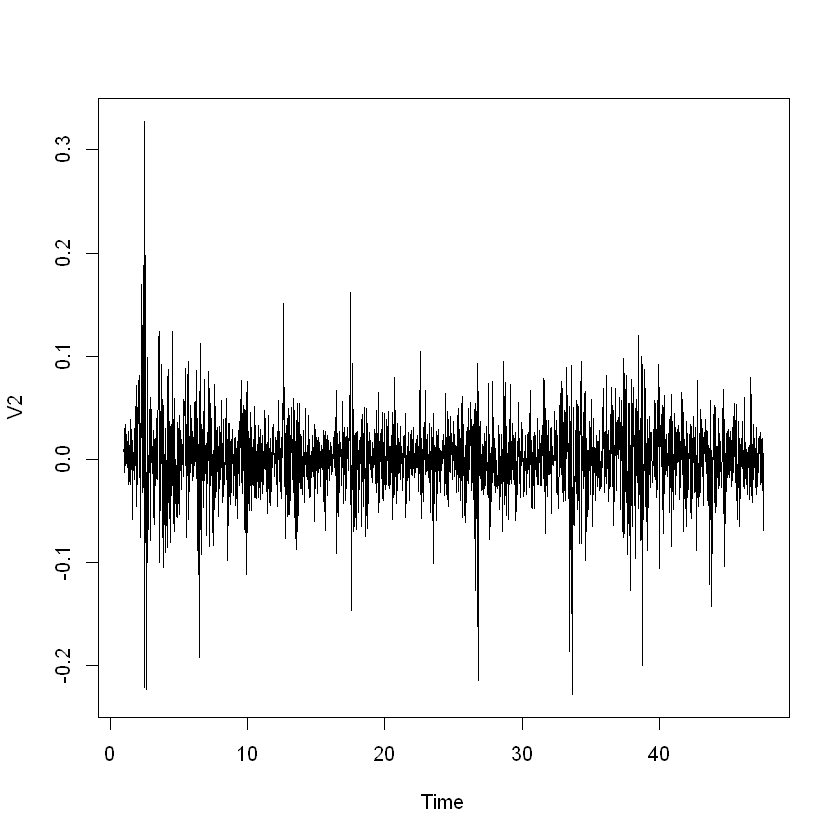

In [7]:
# par(pin = c(6,4))
datalog <- log(data_ts)
datadiff <- diff(datalog, differences=1)
plot.ts(datadiff)

# 上面都是在胡扯
# 下面是根据老师的代码写的

In [8]:
# 设置工作目录并读取数据
setwd('../dataset/期货价格数据/使用数据/')
da <- read.csv("./黄金周数据.csv",head=F)
names(da) <- c('date','price')
head(da)

,date,price
,<chr>,<dbl>
1,2008/1/14,223.30
2,2008/1/21,223.80
3,2008/1/28,206.42
4,2008/2/4,222.56
5,2008/2/11,215.26
6,2008/2/18,213.69


A Time Series:
[1] 223.30 223.80 206.42 222.56 215.26 213.69

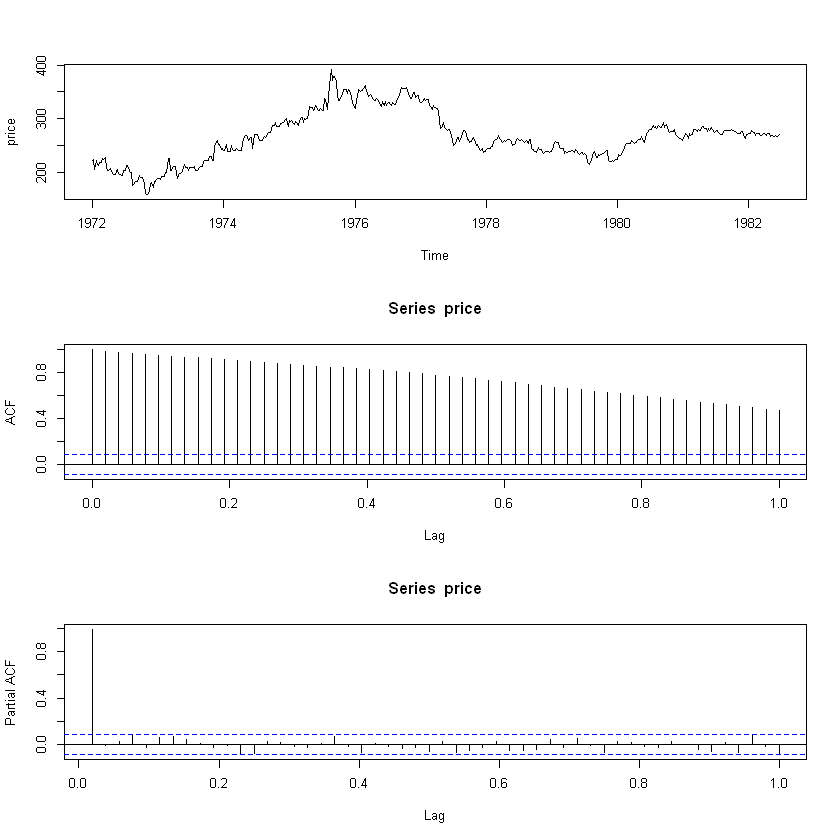

In [9]:
# 转换为时间序列
price = ts(da$price,frequency=52,start=c(1972,1,10))
head(price)
par(mfcol = c(3,1))
plot.ts(price)
acf(price,lag=52)
pacf(price,lag=52)

从上图中可以看到，数据具有一定的趋势性，黄金的价格随着经济的增长和衰退呈现趋势性变化，对其进行自相关检验和偏自相关检验即可发现，其自相关图为拖尾结构，偏自相关图为2阶截尾结构，故根据 ACF 和 PACF 定阶准则，我们应选择AM(2)模型对数据进行建模。

In [10]:
# 进行adf检验
# adf.test(price,k=1)
# adf.test(returns,k=1)
adfTest(price, lags = 0, type = 'ct')
# 无法通过adf检验，故序列不平稳，因此取对数差分消除趋势之后再进行模型的建立。


Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -1.7499
  P VALUE:
    0.6842 

Description:
 Sun Apr 11 19:49:04 2021 by user: 11973


In [11]:
# 计算对数差分收益率
price_log <- log(price)
returns <- diff(price_log, differences=1)
head(returns)
sample_returns <- diff(price,differences = 1)
head(sample_returns)

A Time Series:
[1]  0.002236637 -0.080839868  0.075283800 -0.033350128 -0.007320233
[6]  0.021710298

A Time Series:
[1]   0.50 -17.38  16.14  -7.30  -1.57   4.69

Warning message in adfTest(sample_returns, lags = 0, type = "ct"):
"p-value smaller than printed p-value"



Title:
 Augmented Dickey-Fuller Test

Test Results:
  PARAMETER:
    Lag Order: 0
  STATISTIC:
    Dickey-Fuller: -23.1068
  P VALUE:
    0.01 

Description:
 Sun Apr 11 19:49:05 2021 by user: 11973


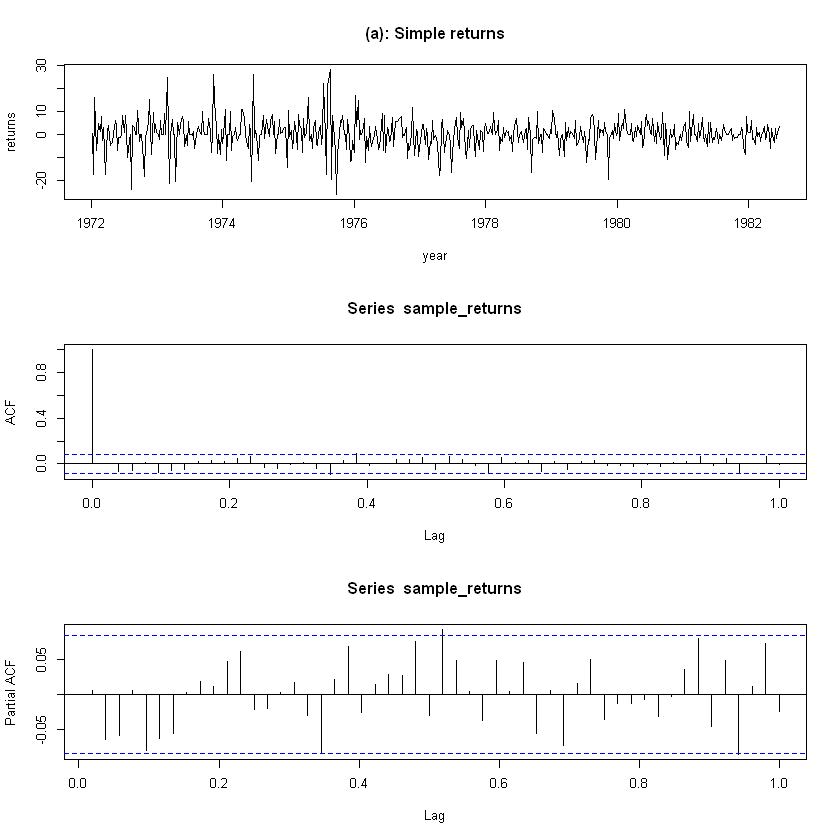

In [12]:
# 进行acf检验
par(mfcol = c(3,1))
plot(sample_returns,xlab='year',ylab='returns')
title(main='(a): Simple returns')
acf(sample_returns,lag=52)
pacf(sample_returns,lag=52)
# acf 1阶截尾， pacf 0 阶截尾 ， 故建立 101 arma模型
adfTest(sample_returns, lags = 0, type = 'ct')
# adf 检验通过，序列平稳 （这个检验放在acf之前说）

, , 1

               [,1]
 [1,]  1.0000000000
 [2,] -0.0008958461
 [3,] -0.0752075594
 [4,] -0.0410657964
 [5,] -0.0400923794
 [6,] -0.0696748192
 [7,] -0.0138059076
 [8,] -0.0599032059
 [9,] -0.0060400759
[10,]  0.0638769324
[11,]  0.0410742815
[12,]  0.0433260156
[13,]  0.0427193590
[14,] -0.0139690887
[15,] -0.0380215330
[16,] -0.0169620779
[17,] -0.0201214857
[18,] -0.0459361358
[19,] -0.0809215273
[20,]  0.0353434268
[21,]  0.1096166823
[22,]  0.0049791858
[23,]  0.0019584213
[24,]  0.0015549918
[25,]  0.0398671305

[1] 0.9972935

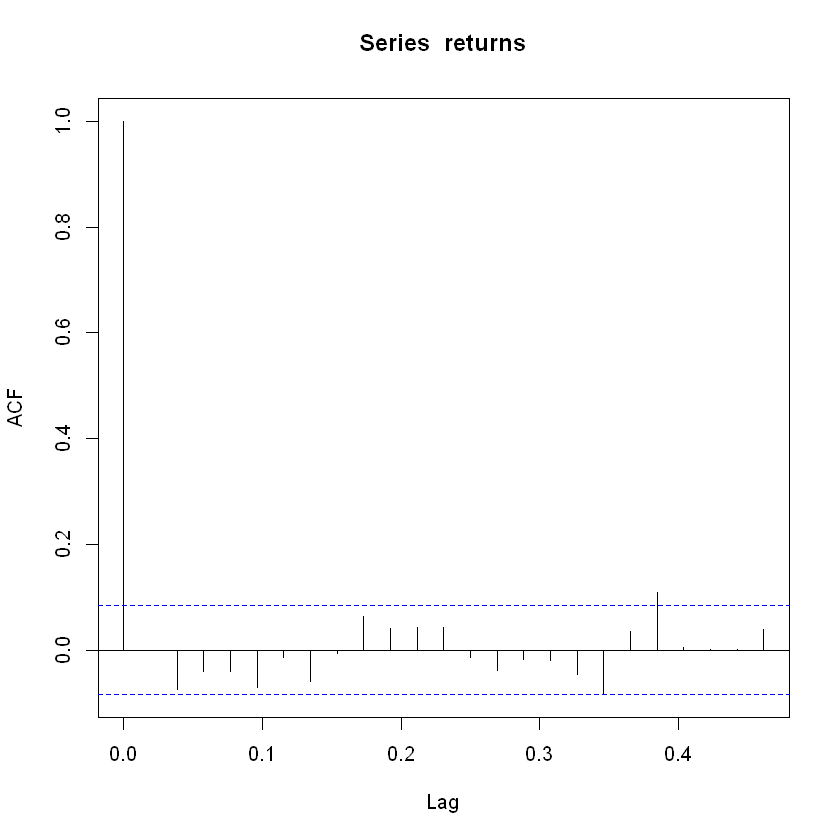

In [13]:
# 检验单个acf 这段不知道在干什么
f1=acf(returns,lag=24)
f1$acf
tt=f1$acf[13]*sqrt(dim(da)[1])
tt

In [14]:
# Ljung-Box Q statistics 白噪声检验
# lnibm=log(ibm+1) # Transfer to log returns
Box.test(sample_returns,lag=log(length(sample_returns)),type='Ljung')
# Box.test(price_log,lag=12,type='Ljung')
# 


	Box-Ljung test

data:  sample_returns
X-squared = 9.0497, df = 6.2989, p-value = 0.1928


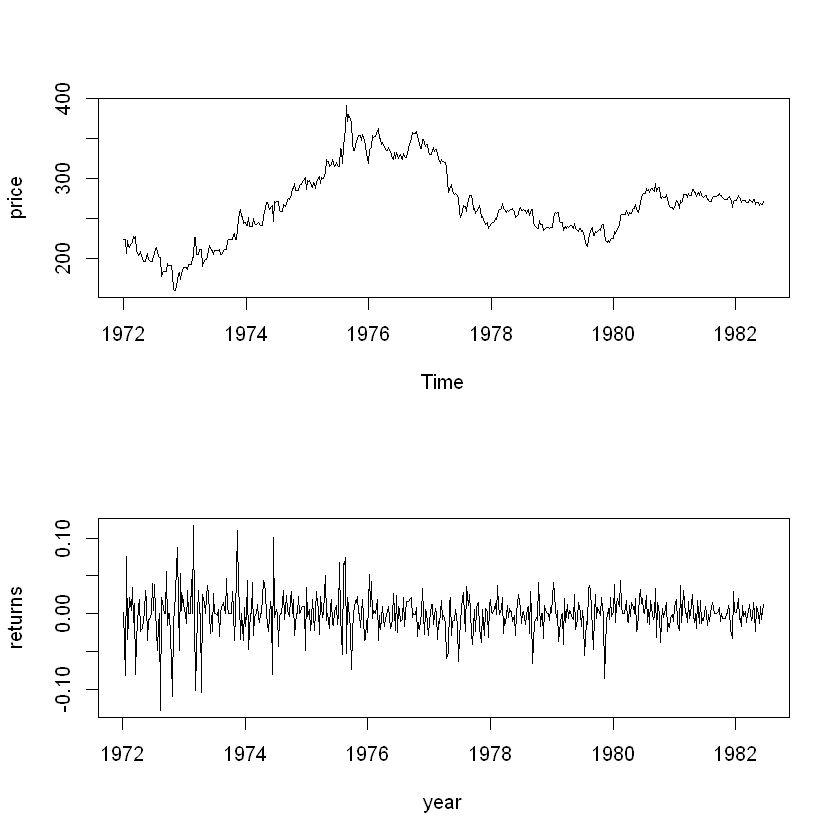

In [15]:
# AR models
par(mfcol=c(2,1))
plot.ts(price)
plot(returns,xlab='year',ylab='returns')

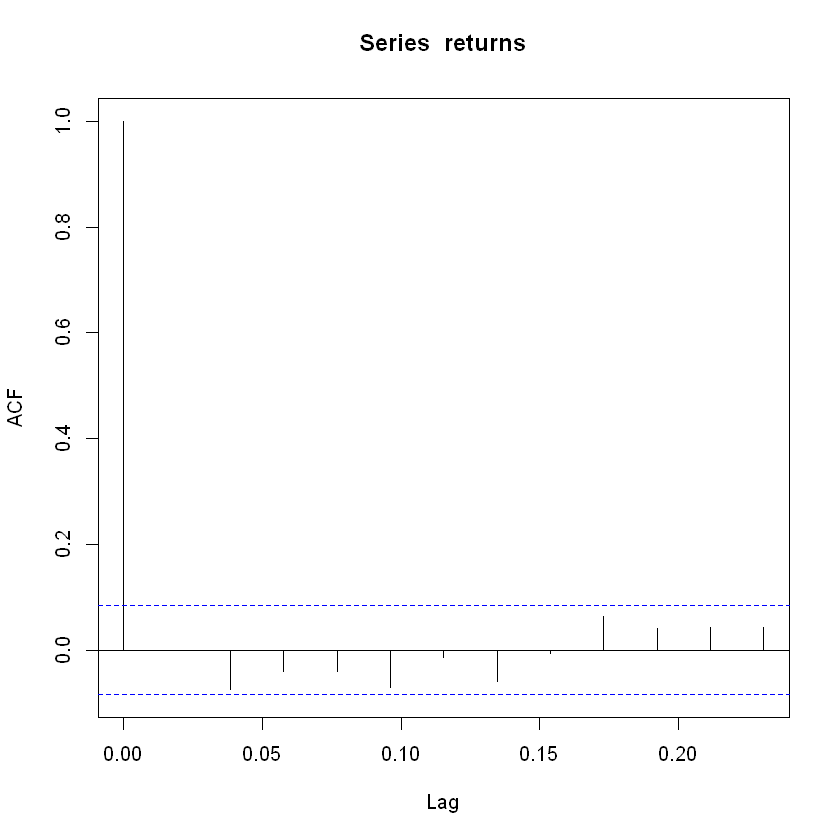

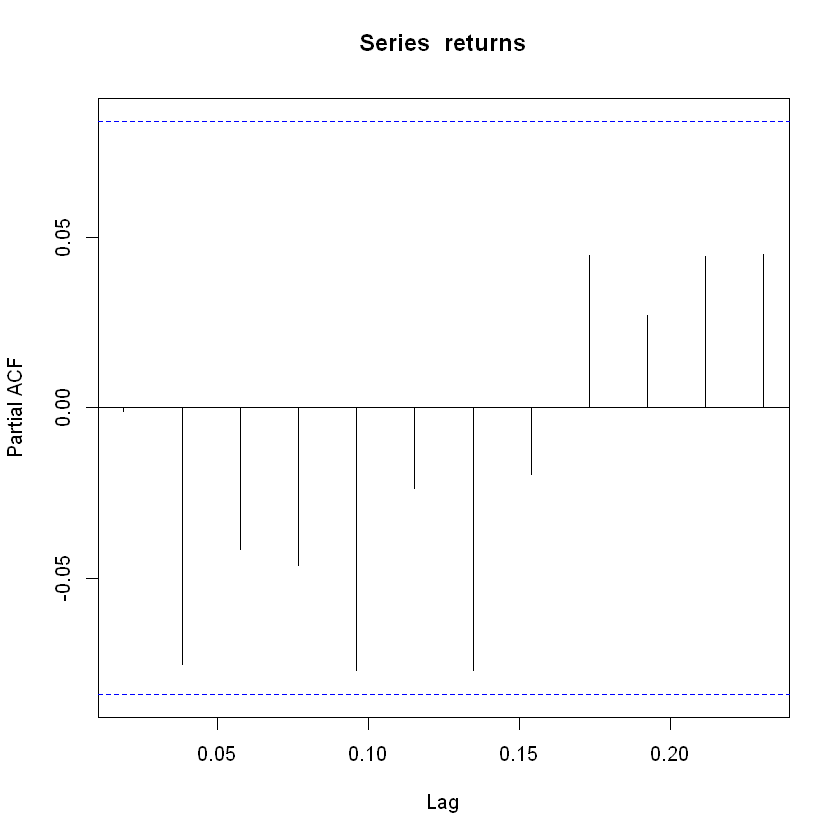

In [16]:
acf(returns,lag=12)
pacf(returns,lag=12) # compute PACF

In [ ]:
m1=arima(returns,order=c(3,0,0))
m1
m12=arima(returns,order=c(1,0,0))
m12
m13=arima(returns,order=c(2,0,0))
m13
m14=arima(returns,order=c(1,0,2))
m14
m15=arima(returns,order=c(3,0,2))
m15
m = auto.arima(sample_returns)
m


Call:
arima(x = returns, order = c(3, 0, 0))

Coefficients:
          ar1      ar2      ar3  intercept
      -0.0041  -0.0757  -0.0414      4e-04
s.e.   0.0428   0.0431   0.0435      1e-03

sigma^2 estimated as 0.0006331:  log likelihood = 1231.32,  aic = -2452.64


Call:
arima(x = returns, order = c(1, 0, 0))

Coefficients:
          ar1  intercept
      -0.0009     0.0004
s.e.   0.0428     0.0011

sigma^2 estimated as 0.0006379:  log likelihood = 1229.3,  aic = -2452.6


Call:
arima(x = returns, order = c(2, 0, 0))

Coefficients:
          ar1      ar2  intercept
      -0.0009  -0.0764      4e-04
s.e.   0.0427   0.0431      1e-03

sigma^2 estimated as 0.0006342:  log likelihood = 1230.87,  aic = -2453.74


Call:
arima(x = returns, order = c(1, 0, 2))

Coefficients:
         ar1      ma1      ma2  intercept
      0.6305  -0.6428  -0.0844      4e-04
s.e.  0.1534   0.1566   0.0479      8e-04

sigma^2 estimated as 0.0006288:  log likelihood = 1233.17,  aic = -2456.35

Warning message in sqrt(diag(x$var.coef)):
"产生了NaNs"



Call:
arima(x = returns, order = c(3, 0, 2))

Coefficients:
         ar1     ar2      ar3      ma1      ma2  intercept
      0.2018  0.3057  -0.0449  -0.2136  -0.3901      4e-04
s.e.     NaN     NaN      NaN      NaN      NaN      8e-04

sigma^2 estimated as 0.0006287:  log likelihood = 1233.21,  aic = -2452.42

In [ ]:
tsdiag(m1,gof=12)  # model checking discussed later

In [ ]:
p1=c(1,-m1$coef[1:3]) # set-up the polynomial
r1=polyroot(p1) # solve the polynomial equation
r1
Mod(r1)
k=2*pi/acos(1.616116/1.832674) # compute length of the period
k

In [ ]:
####AR order identification 
mm1=ar(returns,method='mle')
mm1$order # Find the identified order 
print(mm1$aic,digits=3)
aic=mm1$aic  # For plotting below.
plot(c(0:(length(aic)-1)),aic,type='h',xlab='order',ylab='aic')
lines(0:(length(aic)-1),aic,lty=2)

In [ ]:
#####模型检验
vw=read.table('ch2data\\m-ibm3dx2608.txt',header=T)[,3]
vw
m3=arima(vw,order=c(3,0,0))
m3
(1-.1158+.0187+.1042)*mean(vw)  # Compute the intercept phi(0).
sqrt(m3$sigma2) # Compute standard error of residuals
Box.test(m3$residuals,lag=12,type='Ljung')
pv=1-pchisq(16.35,9) # Compute p value using 9 degrees of freedom
pv

In [ ]:
########模型设定，将参数设为零
m3=arima(vw,order=c(3,0,0),fixed=c(NA,0,NA,NA)) #fix parameter value
m3
(1-.1136+.1063)*.0089  # compute intercept phi(0)
sqrt(m3$sigma2)  # compute residual standard error
Box.test(m3$residuals,lag=12,type='Ljung')#大多数对残差序列应用Ljung-Box统计量时不对自由度进行调整，这与理论不相符合
pv=1-pchisq(16.83,10)#compute p value using 10 freedom
pv

# 按网上的例子来，不进行白噪声检验


In [ ]:
library(tseries)
library(forecast)
# 设置工作目录并读取数据
setwd('../dataset/期货价格数据/使用数据/')

In [ ]:
da <- read.csv("./黄金周数据.csv",head=F)
names(da) <- c('date','price')
head(da)

A Time Series:
[1] 223.30 223.80 206.42 222.56 215.26 213.69

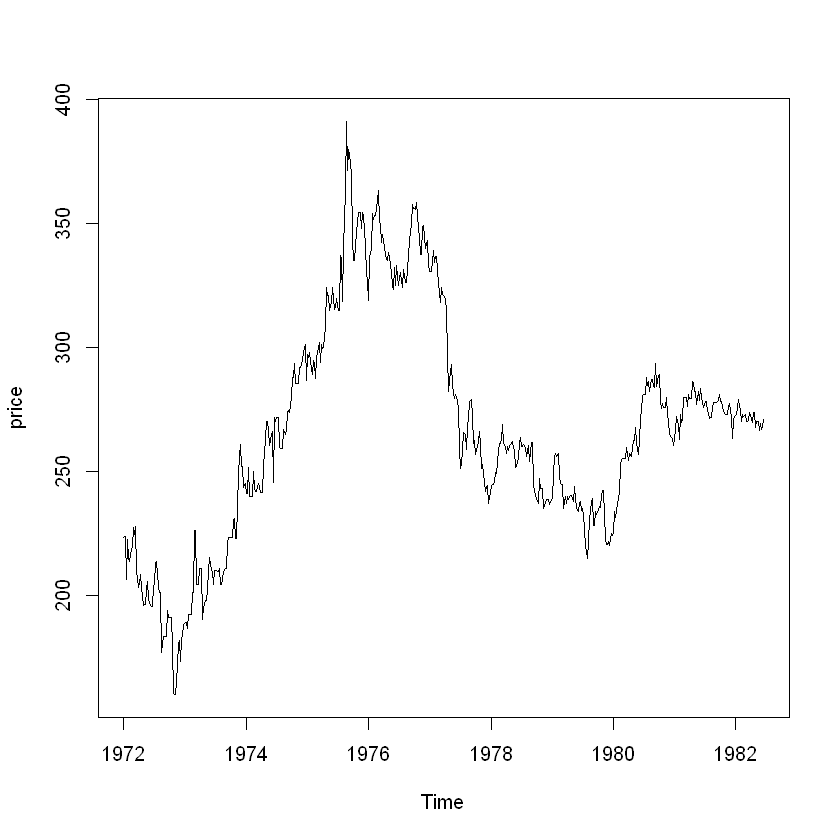

In [5]:
price <- da$price
price = ts(da$price,frequency=52,start=c(1972,1,10))
head(price)
plot.ts(price)

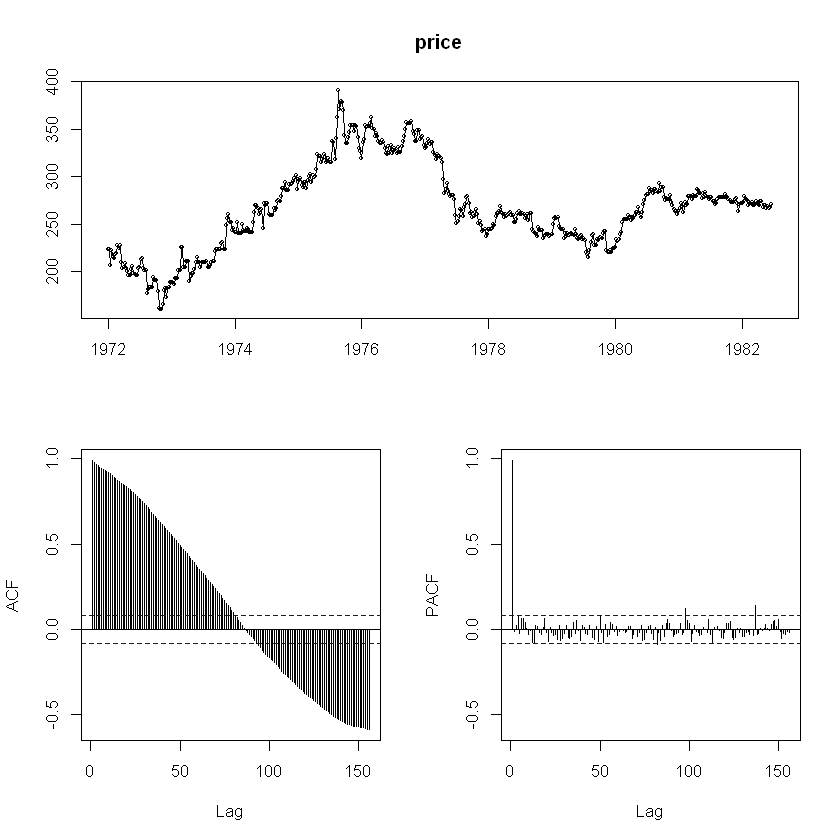

In [6]:
tsdisplay(price)

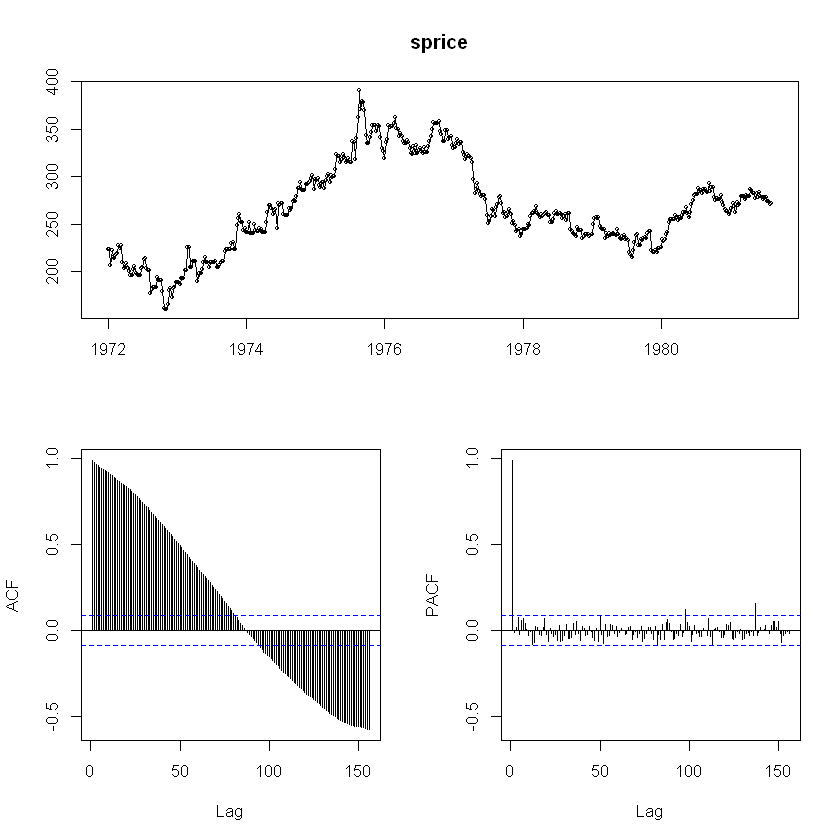

In [7]:
# 拆掉最后一年做样本的测试集
sprice<-ts(as.vector(price[1:500]),frequency=52,start=c(1972,1,10))
tsdisplay(sprice)

Warning message in adf.test(s1):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  s1
Dickey-Fuller = -9.1513, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


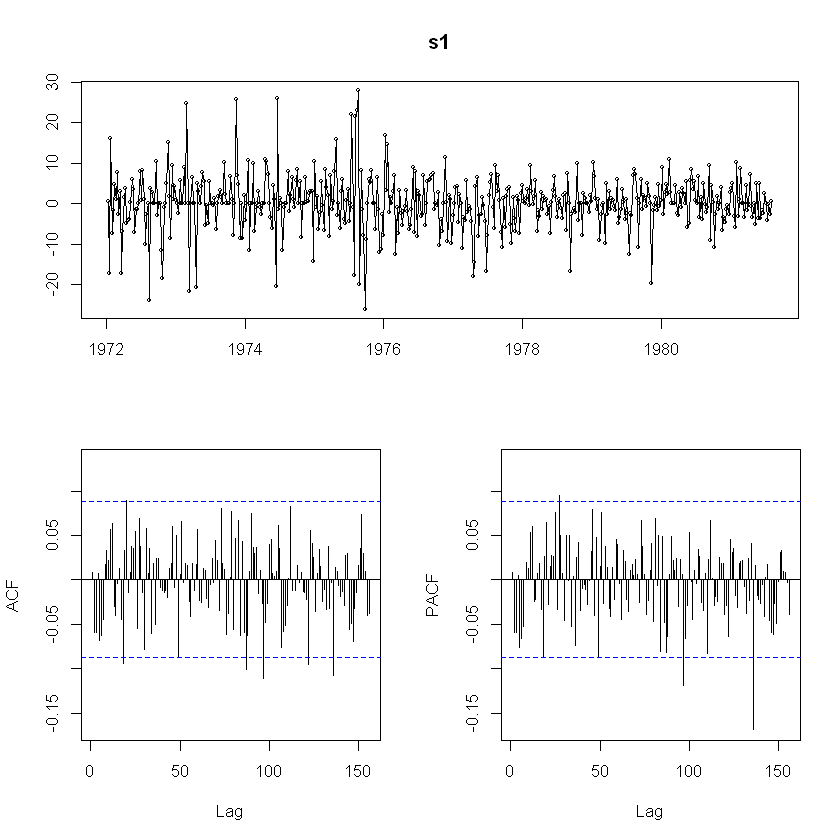

In [9]:
# 明显存在按经济波动增长的趋势，故利用差法将其干掉
s1<-diff(sprice,1)
# 单位根检验判断是否平稳
adf.test(s1)
# 检验通过
tsdisplay(s1)

In [ ]:
# 图像显示acf与pac均存在截尾情况
# 根据pacf图像可判断 p 取 99 或 140
# 根据acf图像可判断 q 取20 90 100 120 或 140
# 进行模型拟合，看看哪个效果好
a <- auto.arima(sprice)
summary(a)

In [2]:
m1 <- arima(sprice,order=c(1,1,0))#AIC=899.95
arima(sprice,order=c(8,1,0))#AIC=907.17
arima(sprice,order=c(10,1,0))#AIC=909
arima(sprice,order=c(12,1,0))#AIC=905.38
arima(sprice,order=c(16,1,0))#NaNs

ERROR: Error in NCOL(x): 找不到对象'sprice'
